In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
import os
import re
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from IPython.display import display, HTML

from analyze import *
from analyze_scheduler import *
from analyze_interference import extractNodeToCoeffs

In [9]:
dosa_map = {'redis_ycsb': {'latency': 0.06431173599123312, 'throughput': 12353.774674000491},
             'sysbench': {'latency': 57.45297619047619, 'throughput': 17.589404761904763},
             'wrk': {'latency': 20.083637349809663, 'throughput': 16132.564843794456}, 
             'hadoop': {'latency': 21870.081841432228, 'throughput': 46287.3925831202}, 
             'linpack': {'throughput': 65.68721468531469}}
baati_map = {'redis_ycsb': {'latency': 0.07430528425750917, 'throughput': 10384.32837495549}, 
             'sysbench': {'latency': 56.348164682539675, 'throughput': 18.479533730158728},
             'wrk': {'latency': 36.990723629522684, 'throughput': 8728.225770278252}, 
             'hadoop': {'latency': 24891.558823529413, 'throughput': 40218.882352941175}, 
             'linpack': {'throughput': 33.166211370517}}
m = {'ip_10_2_1_91': dosa_map, "dosa": dosa_map, 'ip_10_2_1_93': baati_map, "baati": baati_map}

exp_names = ["24scheduler_30_round_robin", "27scheduler_10_round_robin", "26scheduler_20_round_robin" \
            "25scheduler_30_random66"]
ai_counts = [30, 10, 20, 30]

def analyzeSchedule(d, ai_count):
    s = SchedulerExperimentSeries(d, m, ai_count)
    s.printExperimentResults()
    return s

def loadExpSeries(names, m, ai_counts):
    result = []
    for name, ai_count in zip(names, ai_counts):
        s = SchedulerExperimentSeries(os.path.join("data", name), m, ai_count)
        s.computeScheduleSummary()
        result.append(s)
    return result

def presentSchedulerResult(exp_series_list):
    for exp_series in exp_series_list:
        exp_series.printExperimentResults()
        display(exp_series.schedules)
        #display(HTML(exp_series.schedules.to_html()))
        

def plotActualVsExpectedCostMultipleSeries(exp_series_list, node_to_coeffs):
    for exp_series in exp_series_list:
        print(exp_series.name)
        for c in sorted(exp_series.df["composition_id"].unique()):
            plotActualVsExpectedCost(exp_series, node_to_coeffs, c)
            
def findMissingAIData(exp_series, n):
    expids = exp_series.df["expid"].unique()
    expected = sorted([f"ai_{i}" for i in range(1, n+1)])
    result = {}
    for expid in expids:
        partial_result = []
        df = exp_series.df
        actual = df.loc[df["expid"] == expid, "ai_name"].unique()
        for ai_name in expected:
            if ai_name not in actual:
                partial_result.append(ai_name)
        result[expid] = partial_result
    return result

def analyzeInterferenceHelper(name, tasks=("redis_ycsb", "wrk", "hadoop", "linpack"), node="dosa", 
                              skip_cpu=True):
    path = os.path.join("data", name)
    options = {"interval_boundaries": "first_plus_interval"} 
    s = ExperimentSeries(path, tasks, {"hadoopslave": 2}, options, node=node)
    readPerfVsCpu(s, skip_cpu=skip_cpu)
    analyzeInterferenceGrid(s, inverse_throughput_y=True, fit_intercept=False)
    return s

In [8]:
getRescaleFactorMap(["baati", "dosa"], [s0, s1])

Aggregate 0sysbench_interference_baati redis_ycsb latency 4
Aggregate 0sysbench_interference_baati redis_ycsb throughput 4
Aggregate 0sysbench_interference_baati sysbench latency 4
Aggregate 0sysbench_interference_baati sysbench throughput 4
Aggregate 0sysbench_interference_baati hadoop latency 4
Aggregate 0sysbench_interference_baati hadoop throughput 4
Aggregate 0sysbench_interference_baati linpack throughput 4
Aggregate 1sysbench_interference_dosa redis_ycsb latency 4
Aggregate 1sysbench_interference_dosa redis_ycsb throughput 4
Aggregate 1sysbench_interference_dosa sysbench latency 4
Aggregate 1sysbench_interference_dosa sysbench throughput 4
Aggregate 1sysbench_interference_dosa hadoop latency 4
Aggregate 1sysbench_interference_dosa hadoop throughput 4
Aggregate 1sysbench_interference_dosa linpack throughput 4


{'baati': {'redis_ycsb': {'latency': 0.07535628233027027,
   'throughput': 10274.602644208255},
  'sysbench': {'latency': 56.348164682539675,
   'throughput': 18.479533730158728},
  'hadoop': {'latency': 24972.044117647063, 'throughput': 40089.60294117647},
  'linpack': {'throughput': 33.15593417753455}},
 'dosa': {'redis_ycsb': {'latency': 0.06487982593424292,
   'throughput': 12270.403741673312},
  'sysbench': {'latency': 57.45297619047619, 'throughput': 17.589404761904763},
  'hadoop': {'latency': 22259.464194373402, 'throughput': 45584.21611253197},
  'linpack': {'throughput': 65.47580052447552}}}

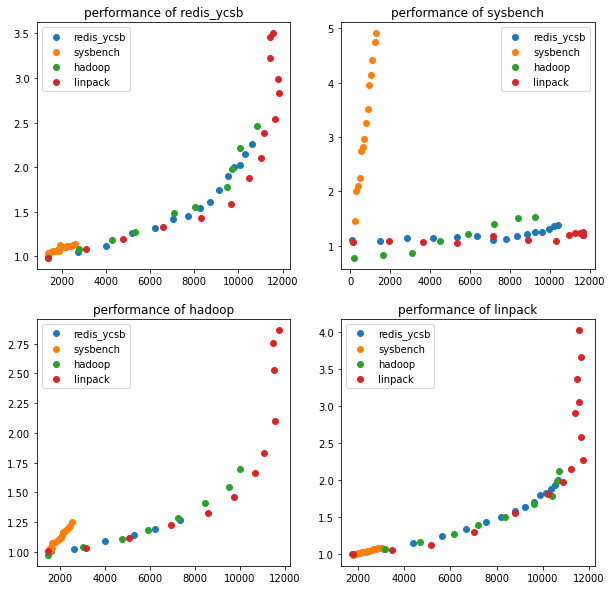

In [16]:
printPerfVsCpuMultipleSeries([s0])

In [10]:
s1 = analyzeInterferenceHelper("1sysbench_interference_dosa", ("redis_ycsb", "sysbench", "hadoop", "linpack"), 
                              skip_cpu=True)

Found 16 experiment in series 1sysbench_interference_dosa
perf vs cpu data/1sysbench_interference_dosa
Getting perf data


KeyboardInterrupt: 

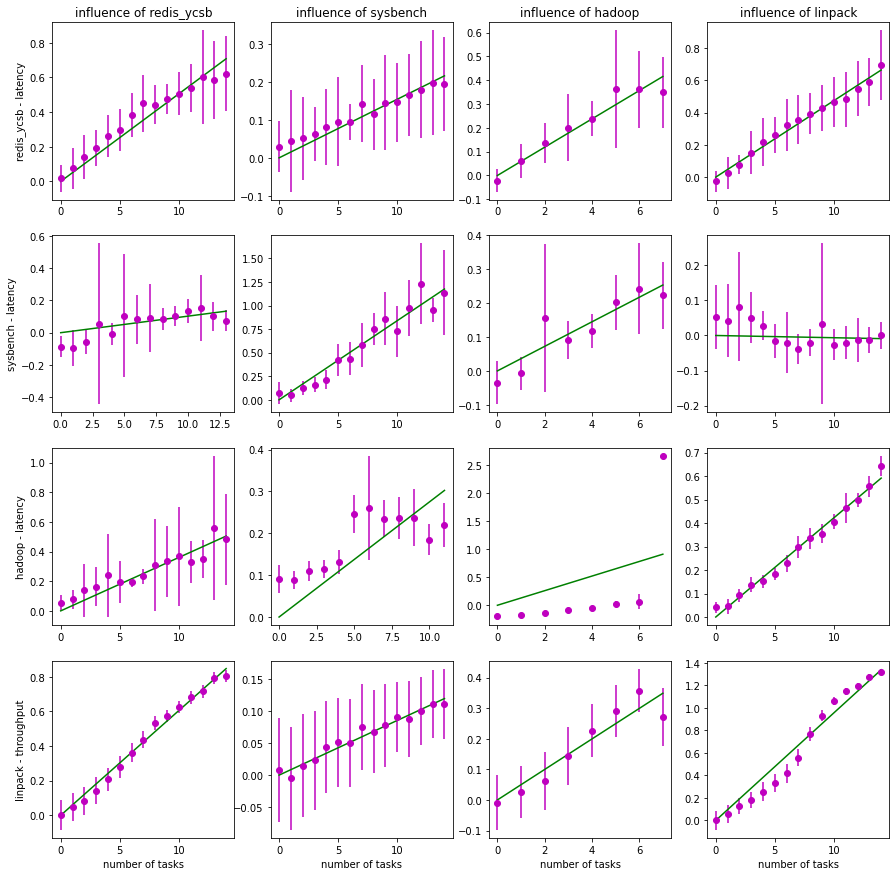

In [15]:
task_pair_to_task_limit = {("sysbench", "redis_ycsb"): 14}
analyzeInterferenceGrid(s1, inverse_throughput_y=True, fit_intercept=False, 
                        task_pair_to_task_limit=task_pair_to_task_limit)

Found 16 experiment in series 0sysbench_interference_baati
perf vs cpu data/0sysbench_interference_baati
Getting perf data
Aggregating perf data


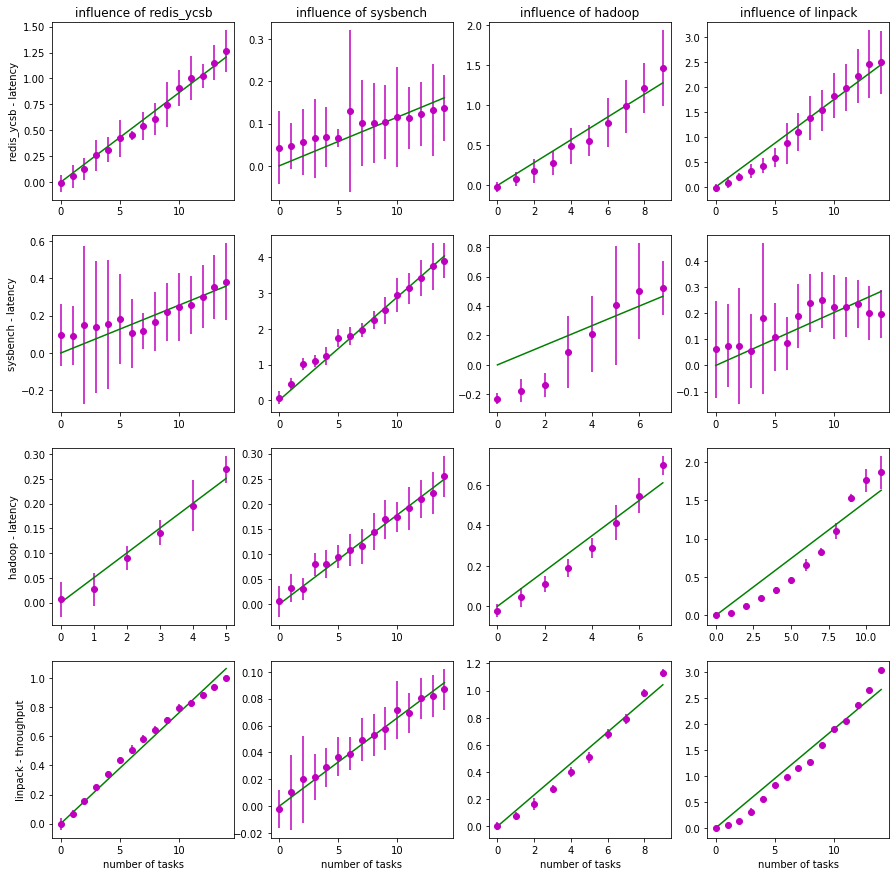

In [7]:
s0 = analyzeInterferenceHelper("0sysbench_interference_baati", ("redis_ycsb", "sysbench", "hadoop", "linpack"), 
                              skip_cpu=True)

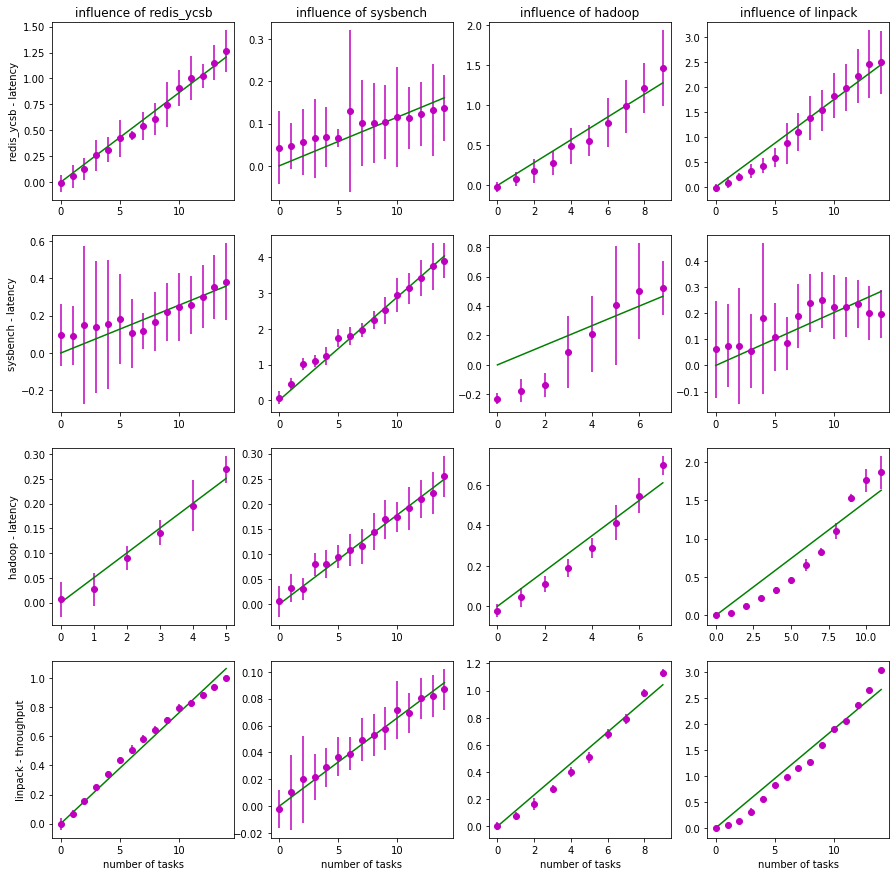

In [21]:
analyzeInterferenceGrid(s0, inverse_throughput_y=True, fit_intercept=False)

Found 2 experiment in series 41hadoop_full_dosa
perf vs cpu data/41hadoop_full_dosa
Getting perf data
Aggregating perf data


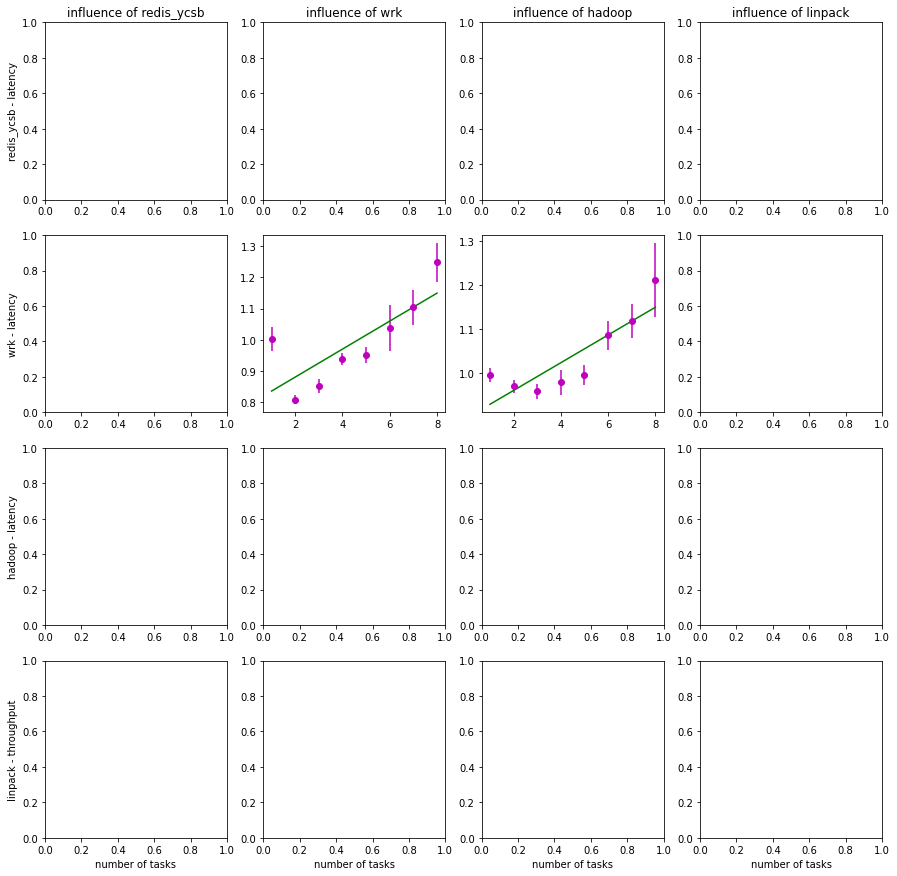

In [9]:
analyzeInterferenceHelper("41hadoop_full_dosa")

Found 2 experiment in series 42hadoop_full_dosa
perf vs cpu data/42hadoop_full_dosa
Getting perf data
Aggregating perf data


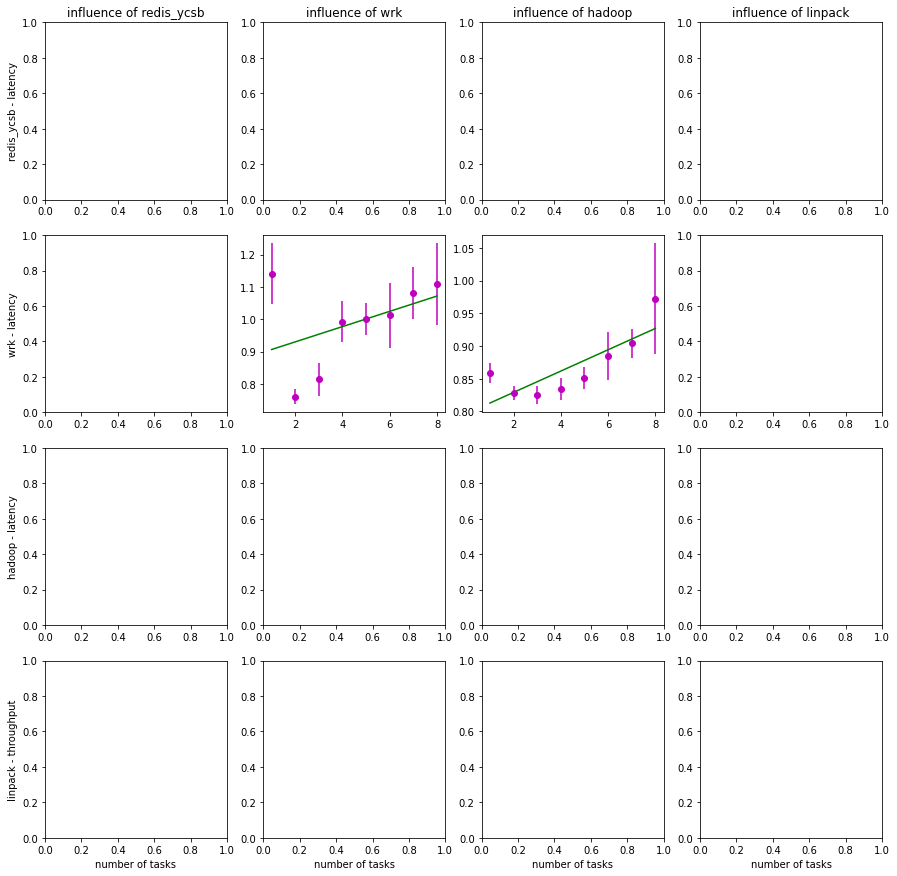

In [10]:
analyzeInterferenceHelper("42hadoop_full_dosa")

Found 4 experiment in series 43wrk_fix_baati
perf vs cpu data/43wrk_fix_baati
Getting perf data
Aggregating perf data


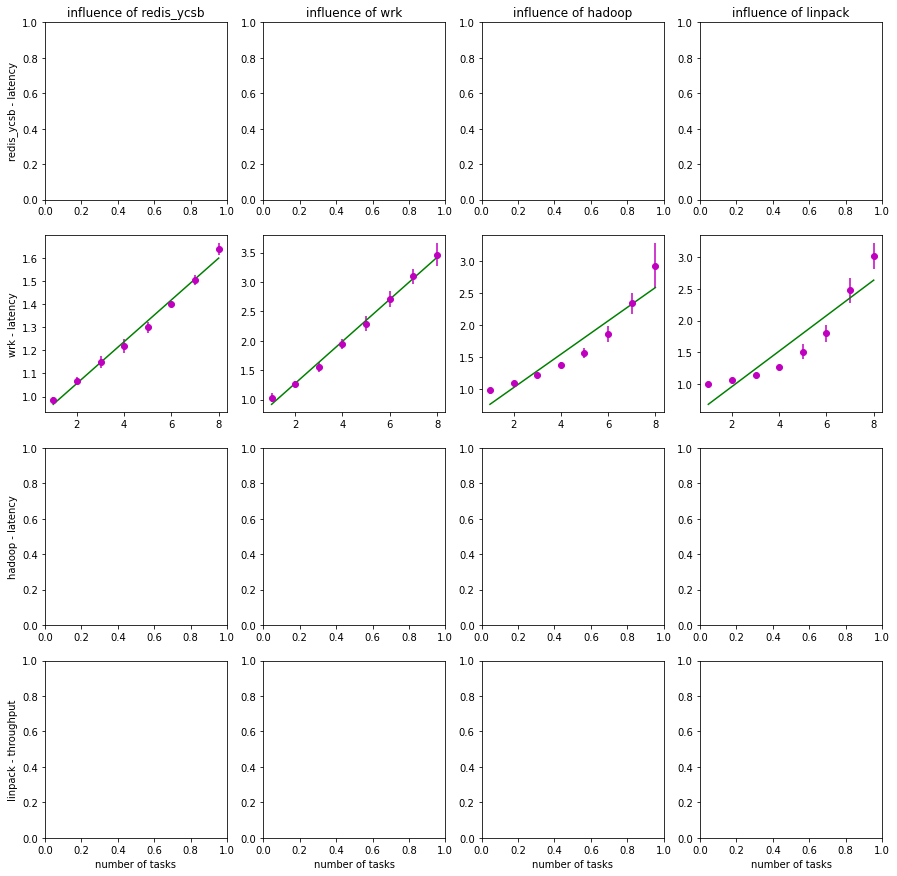

In [13]:
analyzeInterferenceHelper("43wrk_fix_baati")

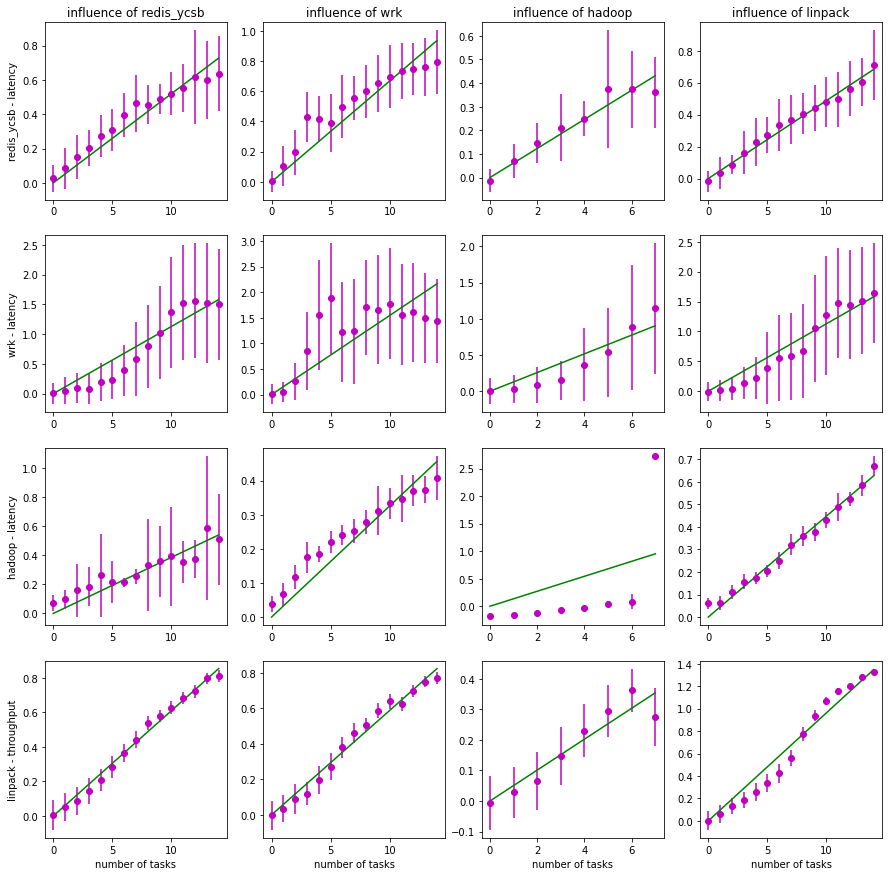

In [44]:
#s4 = analyzeInterferenceHelper("4dosa")
analyzeInterferenceGrid(s4, inverse_throughput_y=True, fit_intercept=False)

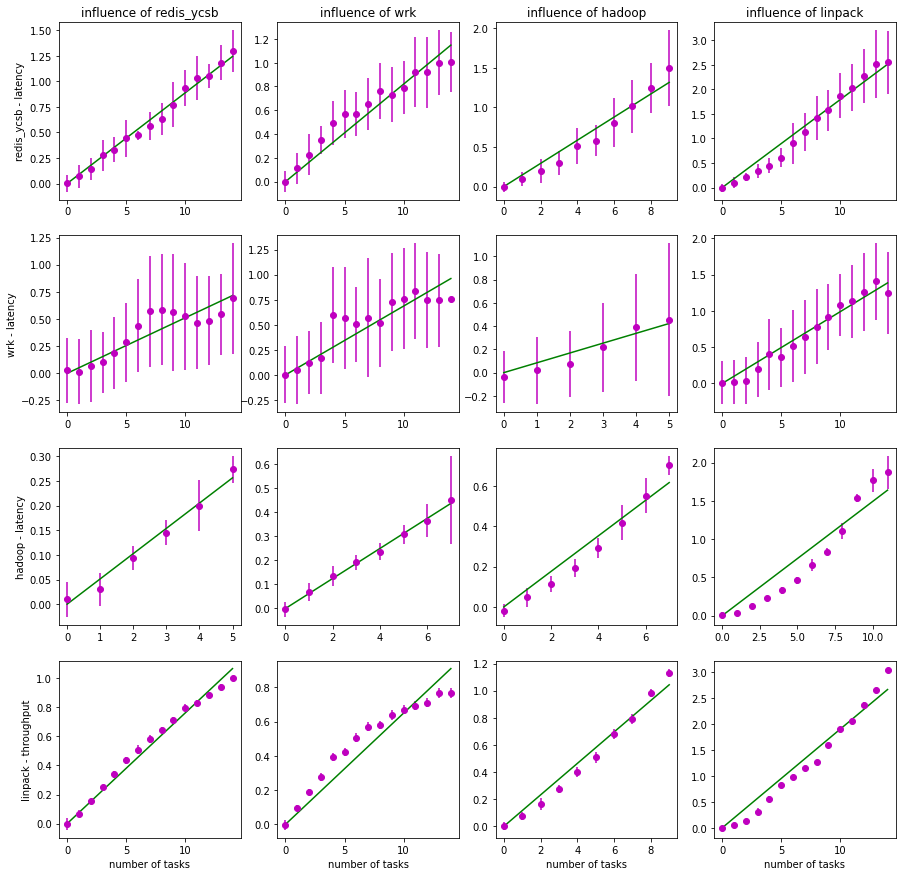

In [47]:
#s3 = analyzeInterferenceHelper("3more_tasks_hadoop")
analyzeInterferenceGrid(s3, inverse_throughput_y=True, fit_intercept=False)

In [24]:
node_to_coeffs = extractNodeToCoeffs([s0, s1])
np.set_printoptions(precision=5)
for node, coeffs in node_to_coeffs.items():
    print(node)
    print(np.array(coeffs))
    
formatInterferenceMatrixInGoFormat([s0, s1])

dosa
[[ 0.05057  0.01541  0.05935  0.04747]
 [ 0.01023  0.0839   0.03616 -0.00063]
 [ 0.03602  0.0275   0.13009  0.04222]
 [ 0.06049  0.00853  0.04981  0.09567]]
"dosa": CoefficientsMatrix{{0.08612842882705371,0.011516487520015056,0.14186391499444775,0.1753592680998369},
{0.0255569940132788,0.28879132169884614,0.0665834554281614,0.020216930367968886},
{0.05019536622941371,0.01780546323429352,0.08703699411998661,0.14818926409734545},
{0.07609368933302638,0.00656678126919528,0.11585616985216249,0.19019220301221867},
},
"dosa": CoefficientsMatrix{{0.05057398416156636,0.01540873975912719,0.059349832450008154,0.047471993890136455},
{0.01023385122289151,0.08390298589395798,0.03615796616934738,-0.0006349613487627833},
{0.03601734046619403,0.027499256859689732,0.13009008601162642,0.042223816951953756},
{0.06048553709345682,0.00853072602767997,0.0498050618880374,0.09567007582122948},
},


In [ ]:
tasks = ["redis_ycsb", "wrk", "hadoop", "linpack"]
path = "data/3more_tasks_hadoop" 
options = {"interval_boundaries": "first_plus_interval"} 
s3 = ExperimentSeries(path, tasks, {"hadoopslave": 2}, options, node="baati")
readPerfVsCpu(s3, skip_cpu=True)
analyzeInterferenceGrid(s3, inverse_throughput_y=True)

In [10]:
tasks = ["redis_ycsb", "wrk", "hadoop", "linpack"]
path = "data/4dosa" 
options = {"interval_boundaries": "first_plus_interval"} 
s4 = ExperimentSeries(path, tasks, {"hadoopslave": 2}, options, node="dosa")
readPerfVsCpu(s4, skip_cpu=True)

Found 16 experiment in series 4dosa
perf vs cpu data/4dosa
Getting perf data
Aggregating perf data


NameError: name 's41' is not defined

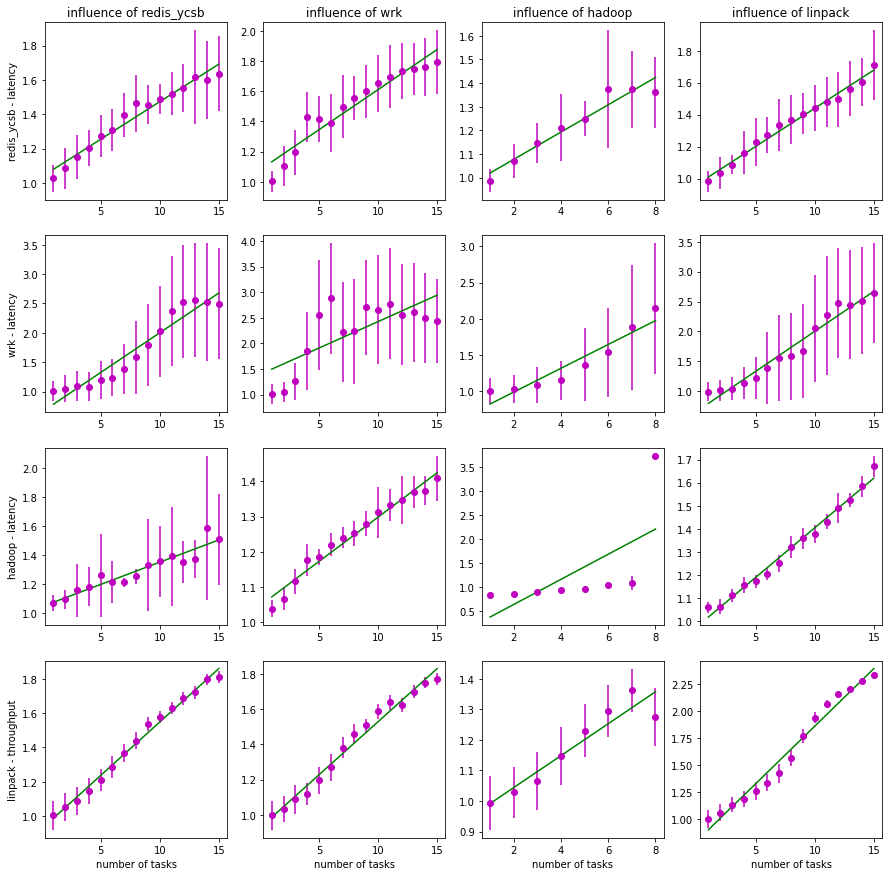

In [11]:
analyzeInterferenceGrid(s4, inverse_throughput_y=True)

In [5]:
from analyze_scheduler import *

def loadExpSeries(names, m, ai_counts):
    result = []
    for name, ai_count in zip(names, ai_counts):
        s = SchedulerExperimentSeries(os.path.join("data", name), m, ai_count)
        s.computeScheduleSummary()
        result.append(s)
    return result

#exp_names = ["31scheduler_3types"]
#exp_names = ["22scheduler_10_random"]
#exp_names = ["27scheduler_10_round_robin"]
#exp_names = ["32scheduler_15_round_robin"]
exp_names = ["100scheduler_sysbench"]
ai_counts = [10]
exp_series_list2 = loadExpSeries(exp_names, m, ai_counts)

presentSchedulerResult(exp_series_list2)

Getting perf data


KeyError: 'sysbench'

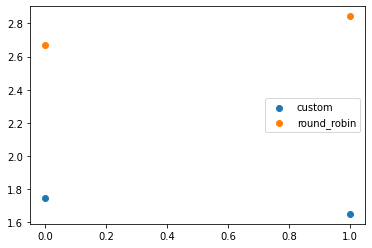

all                               baati             \
                         all redis_ycsb wrk hadoop linpack   all redis_ycsb   
composition scheduler                                                         
90          _custom       15          1   5      7       2     9          0   
            _round_robin  15          1   5      7       2     8          1   
91          _custom       15          3   6      4       2     8          0   
            _round_robin  15          3   6      4       2     7          1   

                                            dosa                                
                         wrk hadoop linpack  all redis_ycsb wrk hadoop linpack  
composition scheduler                                                           
90          _custom        5      4       0    6          1   0      3       2  
            _round_robin   3      3       1    7          0   2      4       1  
91          _custom        6      2       0    7          3   0      2       2  
            _round_robin   3      2       1    8          2   3      2       1

32scheduler_15_round_robin


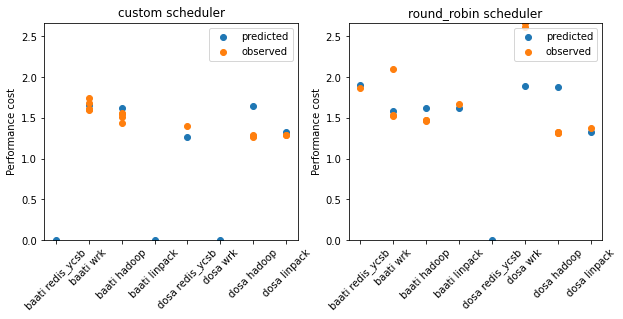

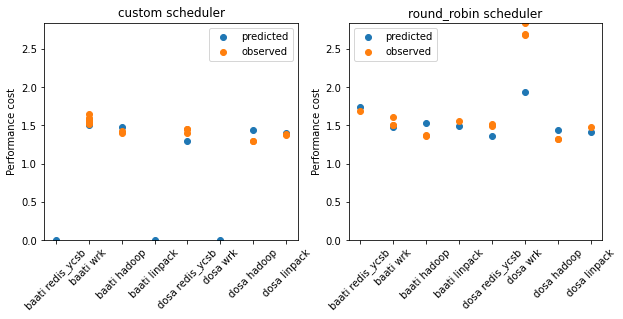

In [25]:
exp_series = exp_series_list2[0]
df = exp_series.dfs["perf"]
pd.set_option("display.max_columns", 50)
df.loc[(df["expid"] == "78scheduler0_random") & (df["ai_name"] == "ai_1"), :]

presentSchedulerResult(exp_series_list2)
plotActualVsExpectedCostMultipleSeries(exp_series_list2, node_to_coeffs)
## presentSchedulerResult(exp_series_list2)

31scheduler_3types


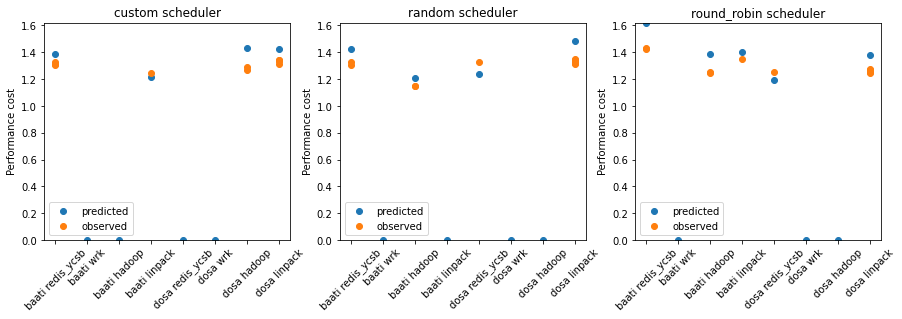

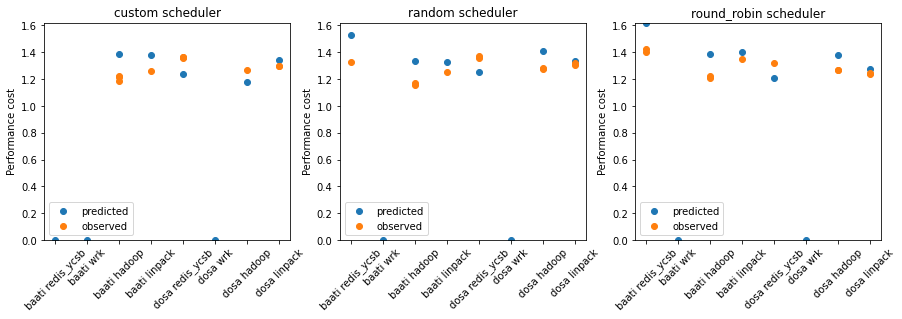

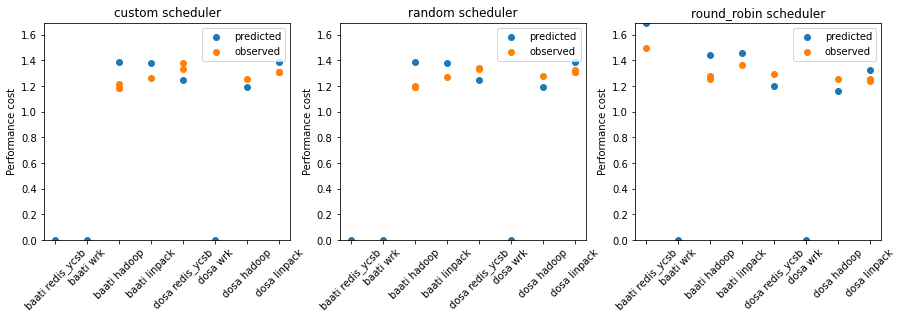

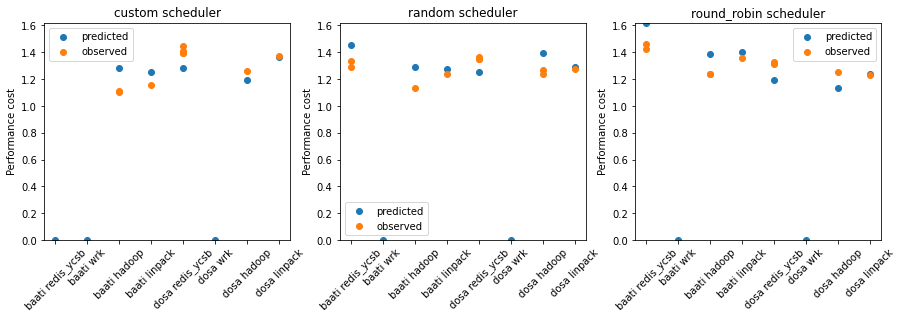

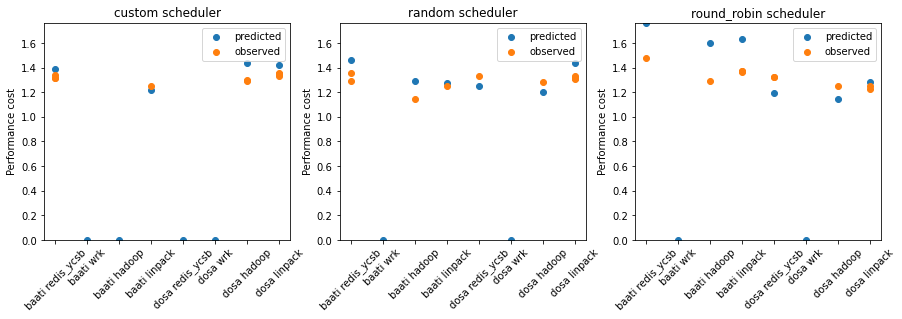

In [16]:
plotActualVsExpectedCostMultipleSeries(exp_series_list2, node_to_coeffs)

In [32]:
from read_data.resource import getCpuDataAllSchedulerExperiment
res = getCpuDataAllSchedulerExperiment(exp_series_list2[0])
df = res["cpu_agg"]
agg = df.groupby(["scheduler", "host"], as_index=False).mean()
agg

Getting cpu data
Aggregating cpu data


,scheduler,host,composition_id,shuffle_id,avg_cpu,std_cpu,cpu_samples_count
0,_custom,baati,53.0,0.0,6403.341131,1491.295716,180.333333
1,_custom,dosa,53.0,0.0,7358.547758,1377.311798,193.000000
2,_round_robin,baati,53.0,0.0,7225.257310,2023.093101,183.000000
3,_round_robin,dosa,53.0,0.0,7263.589669,1050.176228,183.000000


In [7]:
findMissingAIData(exp_series_list2[0], 15)

{'91scheduler0_custom': [],
 '90scheduler0_custom': ['ai_14', 'ai_15'],
 '91scheduler0_round_robin': [],
 '90scheduler0_round_robin': ['ai_13']}

31scheduler_3types


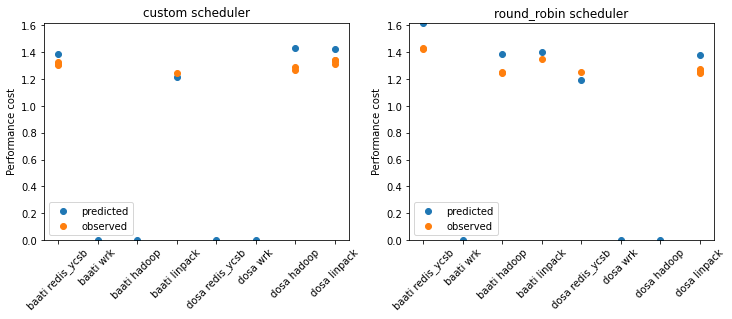

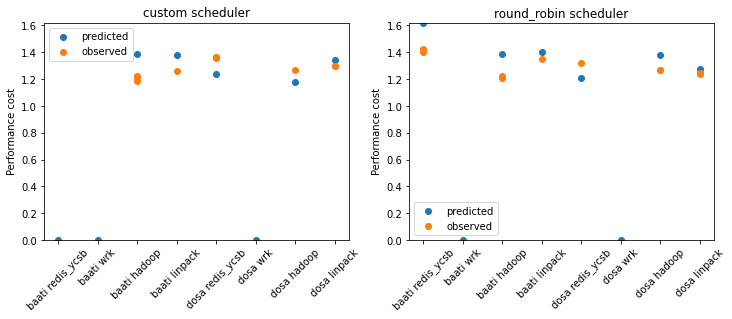

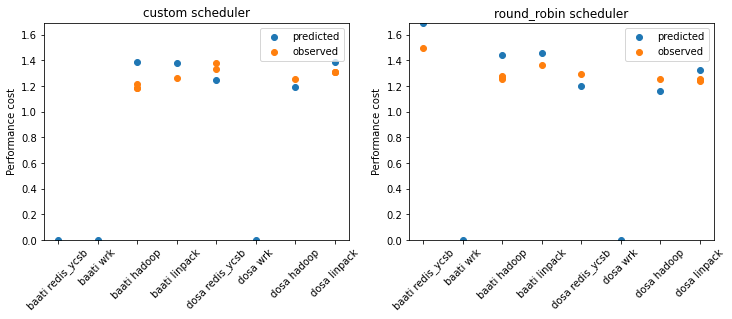

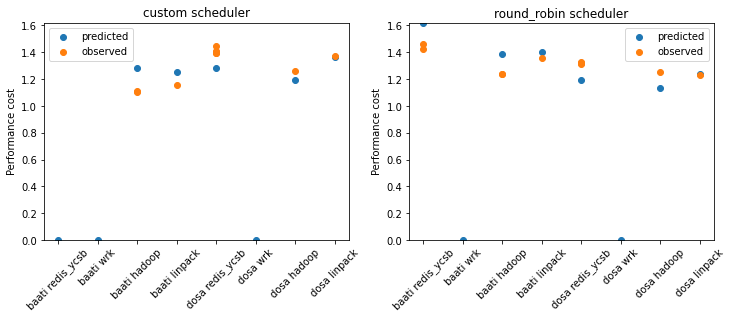

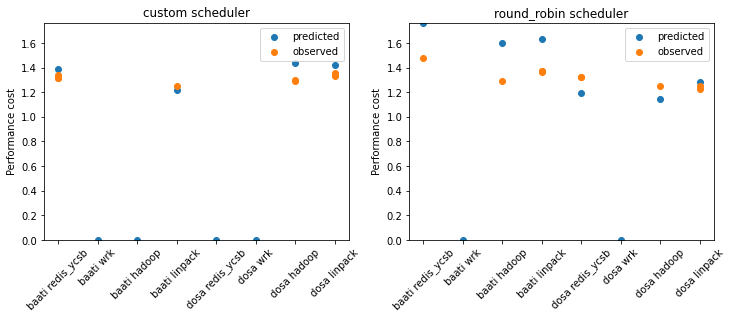

In [11]:
plotActualVsExpectedCostMultipleSeries(exp_series_list2, node_to_coeffs)

In [31]:
"23scheduler_20_round_robin"
exp_names = ["22scheduler_10_random", "27scheduler_10_round_robin", "26scheduler_20_round_robin", "24scheduler_30_round_robin", \
            "25scheduler_30_random66"]
ai_counts = [10, 10, 20, 30, 30]
exp_series_list = loadExpSeries(exp_names, m, ai_counts)

Getting perf data
Getting perf data
Getting perf data
Getting perf data
Getting perf data


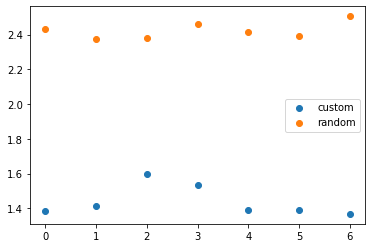

all                               baati                 \
                      all redis_ycsb wrk hadoop linpack   all redis_ycsb wrk   
composition scheduler                                                          
18          _custom    10          3   3      2       2     4          0   3   
            _random     7          3   3      1       0     2          0   2   
19          _custom    10          3   2      2       3     4          0   2   
            _random    10          3   2      2       3     6          2   1   
20          _custom    10          2   3      3       2     5          0   3   
            _random    10          2   3      3       2     6          2   1   
21          _custom    10          5   2      1       2     4          0   2   
            _random    10          5   2      1       2     6          3   1   
22          _custom    10          4   2      2       2     4          0   2   
            _random    10          4   2      2       2     6          3   1   
23          _custom    10          3   2      2       3     4          0   2   
            _random    10          3   2      2       3     5          2   0   
24          _custom    10          2   2      5       1     5          0   2   
            _random    10          2   2      5       1     4          1   0   

                                     dosa                                
                      hadoop linpack  all redis_ycsb wrk hadoop linpack  
composition scheduler                                                    
18          _custom        1       0    6          3   0      1       2  
            _random        0       0    5          3   1      1       0  
19          _custom        1       1    6          3   0      1       2  
            _random        1       2    4          1   1      1       1  
20          _custom        2       0    5          2   0      1       2  
            _random        2       1    4          0   2      1       1  
21          _custom        1       1    6          5   0      0       1  
            _random        0       2    4          2   1      1       0  
22          _custom        1       1    6          4   0      1       1  
            _random        2       0    4          1   1      0       2  
23          _custom        1       1    6          3   0      1       2  
            _random        1       2    5          1   2      1       1  
24          _custom        3       0    5          2   0      2       1  
            _random        3       0    6          1   2      2       1

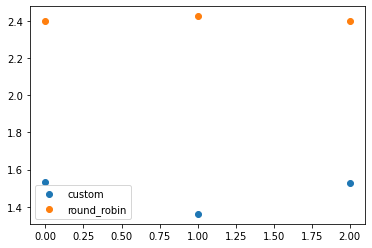

all                               baati             \
                         all redis_ycsb wrk hadoop linpack   all redis_ycsb   
composition scheduler                                                         
52          _custom       10          4   2      2       2     4          0   
            _round_robin  10          4   2      2       2     5          1   
53          _custom       10          4   1      2       3     4          0   
            _round_robin  10          4   1      2       3     5          2   
54          _custom       10          1   6      2       1     6          0   
            _round_robin  10          1   6      2       1     5          1   

                                            dosa                                
                         wrk hadoop linpack  all redis_ycsb wrk hadoop linpack  
composition scheduler                                                           
52          _custom        2      1       1    6          4   0      1       1  
            _round_robin   0      2       2    5          3   2      0       0  
53          _custom        1      2       1    6          4   0      0       2  
            _round_robin   0      1       2    5          2   1      1       1  
54          _custom        6      0       0    4          1   0      2       1  
            _round_robin   3      1       0    5          0   3      1       1

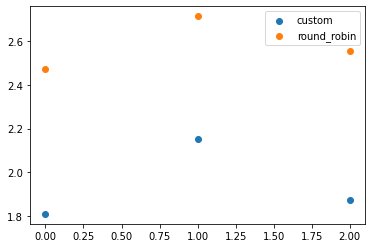

all                               baati             \
                         all redis_ycsb wrk hadoop linpack   all redis_ycsb   
composition scheduler                                                         
55          _custom       18          5   3      4       6     7          0   
            _round_robin  17          5   2      5       5    10          2   
56          _custom       20          4   5      2       9    10          4   
            _round_robin  19          4   4      2       9    10          2   
57          _custom       20          8   6      3       3     9          0   
            _round_robin  18          8   4      3       3    10          5   

                                            dosa                                
                         wrk hadoop linpack  all redis_ycsb wrk hadoop linpack  
composition scheduler                                                           
55          _custom        3      3       1   11          5   0      1       5  
            _round_robin   1      3       4    7          3   1      2       1  
56          _custom        5      0       1   10          0   0      2       8  
            _round_robin   2      0       6    9          2   2      2       3  
57          _custom        6      2       1   11          8   0      1       2  
            _round_robin   3      1       1    8          3   1      2       2

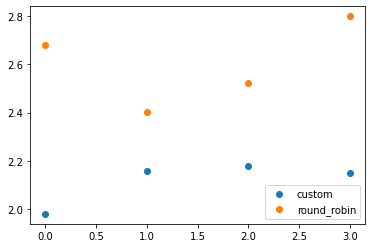

all                               baati             \
                         all redis_ycsb wrk hadoop linpack   all redis_ycsb   
composition scheduler                                                         
42          _custom       25         11   7      3       4     8          0   
            _round_robin  21          9   5      3       4    11          6   
43          _custom       23          9   8      3       3     8          0   
            _round_robin  20          7   6      4       3    14          5   
44          _custom       23          5   7      3       8     7          0   
            _round_robin  20          5   6      2       7     7          5   
45          _custom       27          8   9      4       6    10          0   
            _round_robin  21          8   6      4       3    11          6   

                                            dosa                                
                         wrk hadoop linpack  all redis_ycsb wrk hadoop linpack  
composition scheduler                                                           
42          _custom        7      0       1   17         11   0      3       3  
            _round_robin   3      0       2   10          3   2      3       2  
43          _custom        8      0       0   15          9   0      3       3  
            _round_robin   5      2       2    6          2   1      2       1  
44          _custom        7      0       0   16          5   0      3       8  
            _round_robin   2      0       0   13          0   4      2       7  
45          _custom        9      1       0   17          8   0      3       6  
            _round_robin   3      2       0   10          2   3      2       3

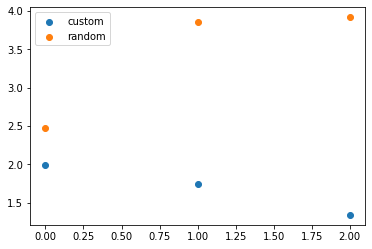

all                               baati                 \
                      all redis_ycsb wrk hadoop linpack   all redis_ycsb wrk   
composition scheduler                                                          
61          _custom    21          4   8      3       6     8          0   8   
            _random    11          4   2      3       2    10          4   1   
62          _custom    20          2  10      3       5    10          0  10   
            _random    23          4  10      3       6     6          2   1   
63          _custom     7          2   1      1       3     1          0   1   
            _random    19          5   8      1       5     8          3   4   

                                     dosa                                
                      hadoop linpack  all redis_ycsb wrk hadoop linpack  
composition scheduler                                                    
61          _custom        0       0   13          4   0      3       6  
            _random        3       2    1          0   1      0       0  
62          _custom        0       0   10          2   0      3       5  
            _random        3       0   17          2   9      0       6  
63          _custom        0       0    6          2   0      1       3  
            _random        1       0   11          2   4      0       5

In [32]:
presentSchedulerResult(exp_series_list)

22scheduler_10_random


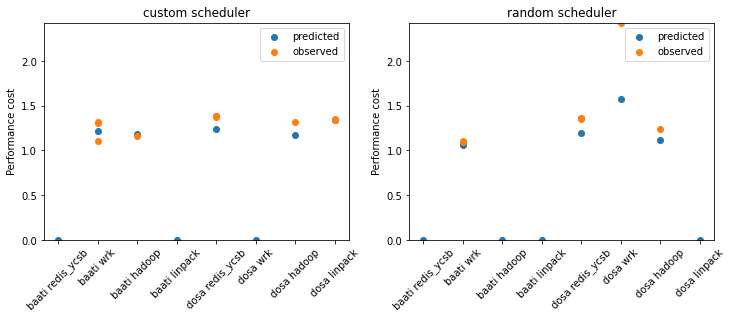

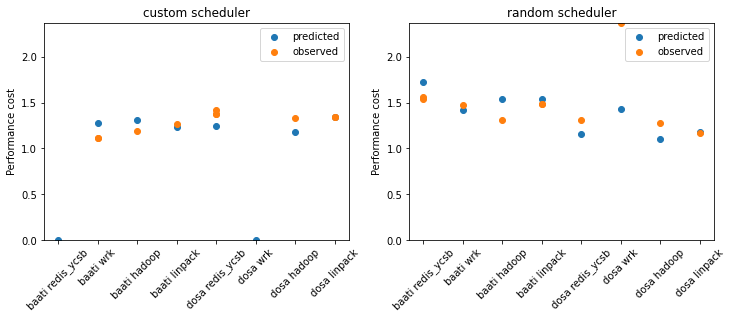

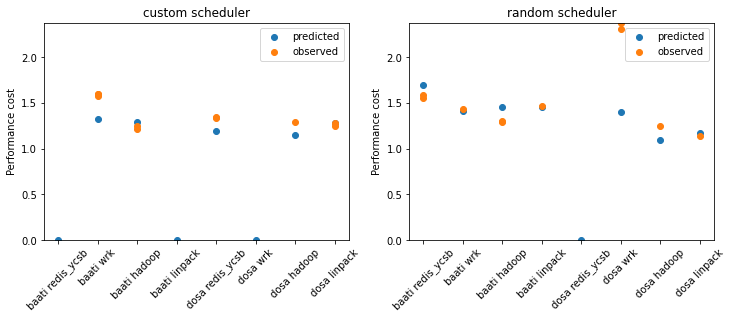

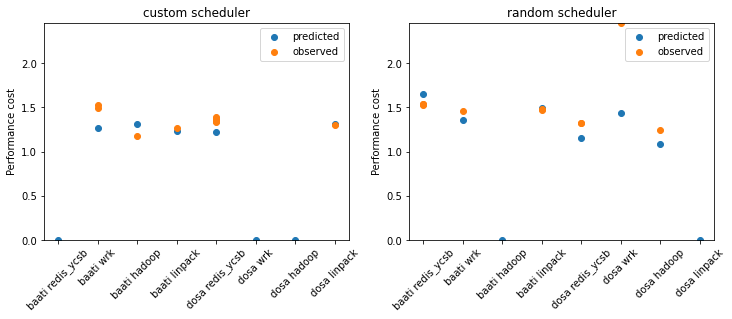

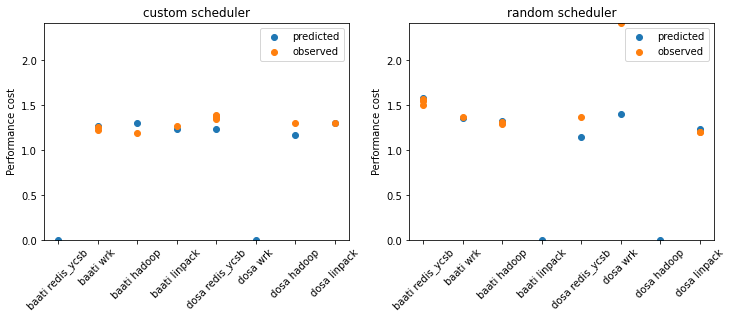

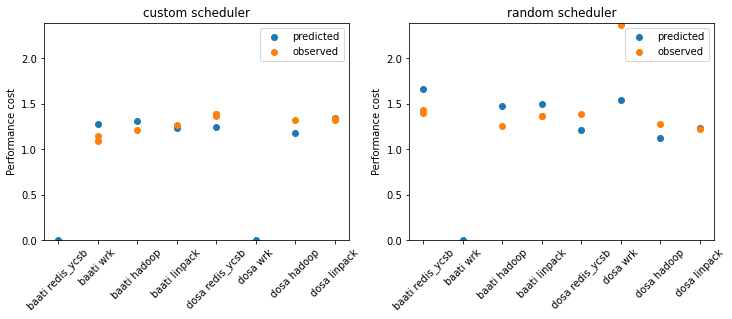

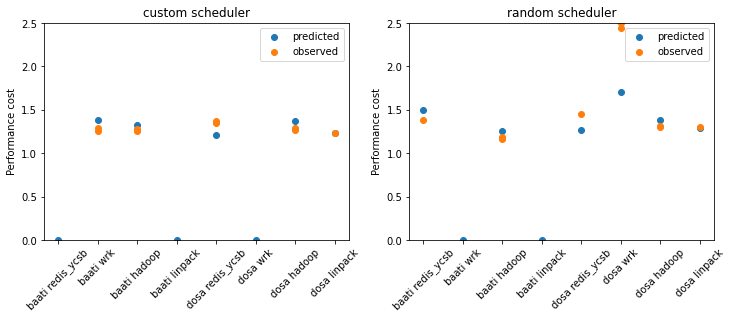

27scheduler_10_round_robin


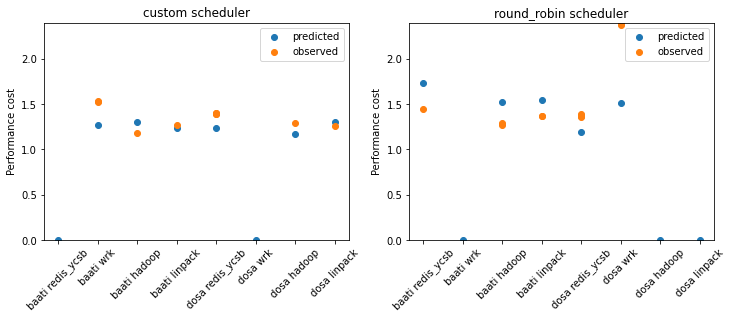

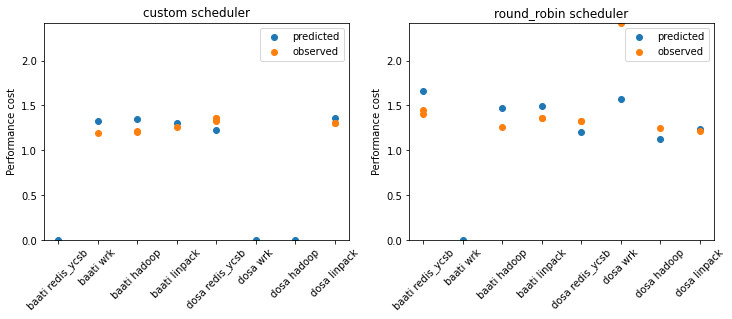

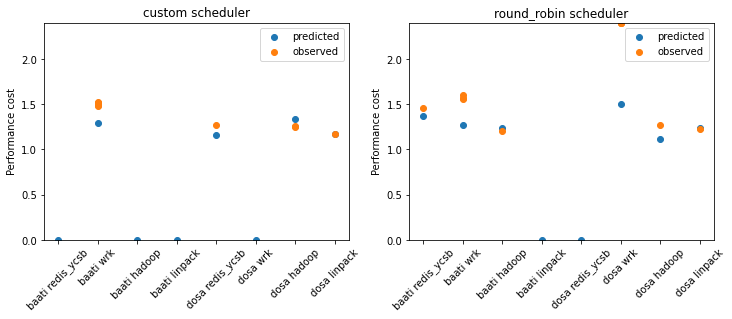

26scheduler_20_round_robin


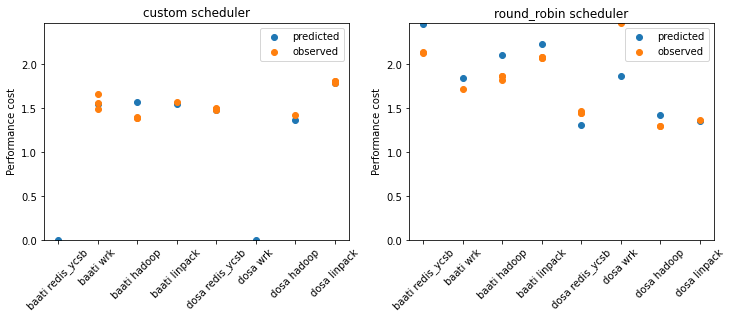

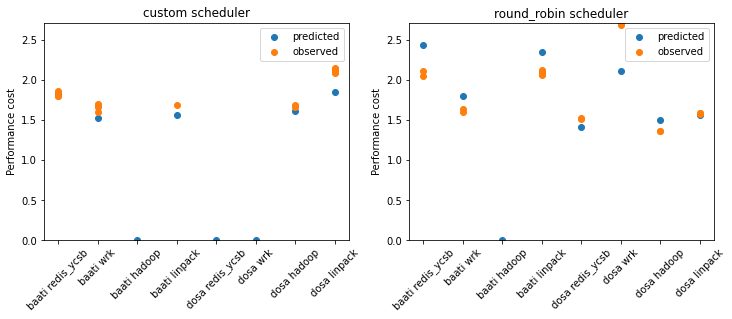

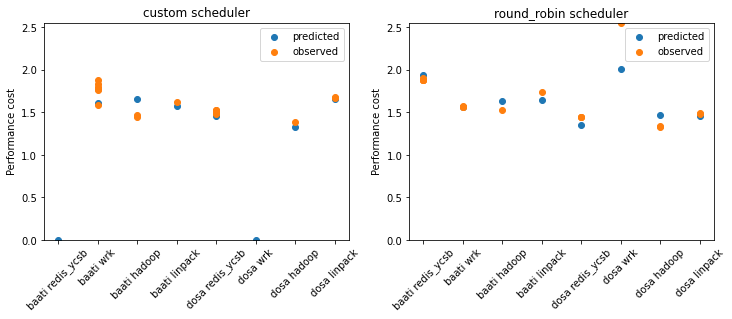

24scheduler_30_round_robin


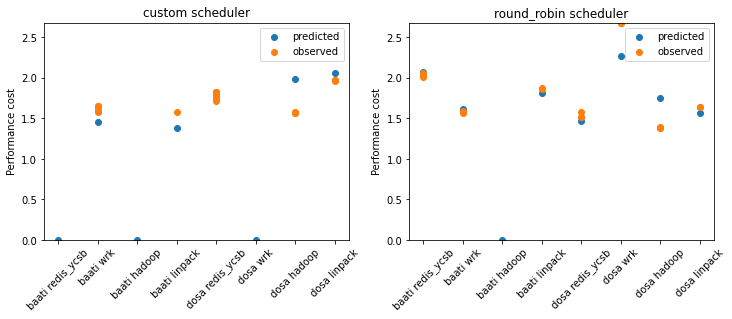

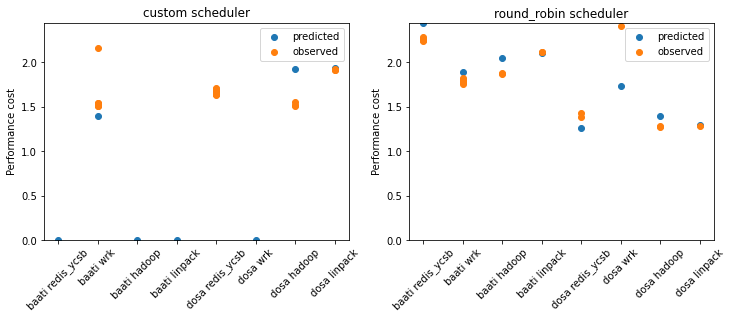

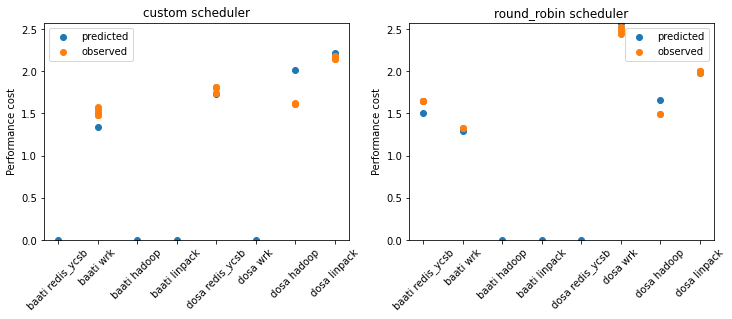

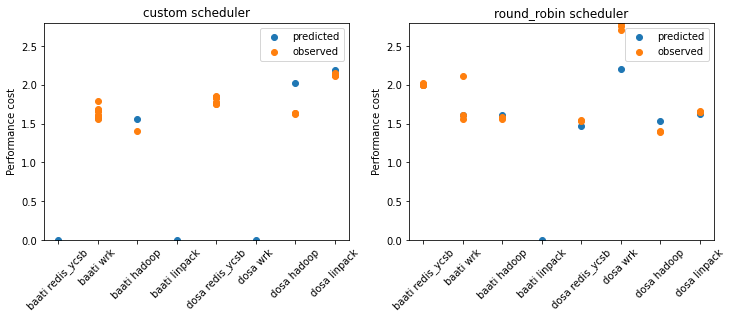

25scheduler_30_random66


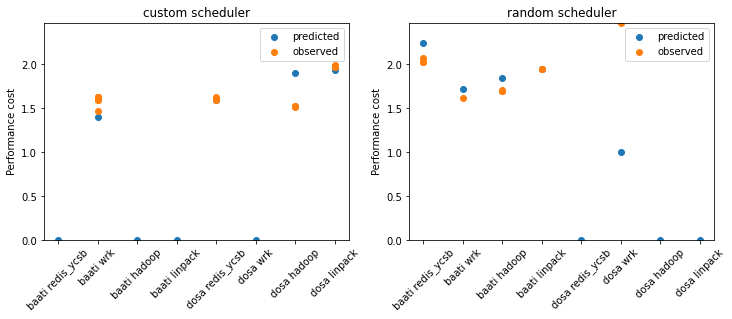

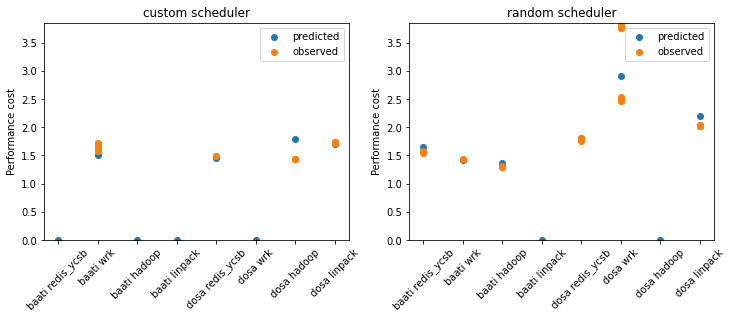

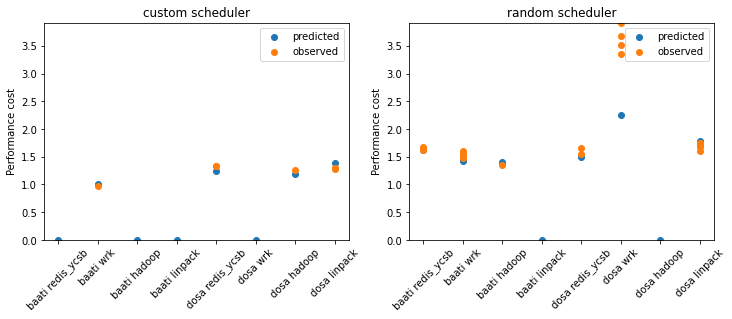

In [36]:
from analyze_interference import computeNodeToCoeffs

def plotActualVsExpectedCostMultipleSeries(exp_series_list, node_to_coeffs):
    for exp_series in exp_series_list:
        print(exp_series.name)
        for c in sorted(exp_series.df["composition_id"].unique()):
            plotActualVsExpectedCost(exp_series, node_to_coeffs, c)

node_to_coeffs = computeNodeToCoeffs([s3, s4])
plotActualVsExpectedCostMultipleSeries(exp_series_list, node_to_coeffs)

In [7]:
from analyze_scheduler import *
#s24 = analyzeSchedule("data/24scheduler_30_round_robin")
#s = analyzeSchedule("data/25scheduler_30_random66")

#computeScheduleSummary(s)
#s.printExperimentResults()
#s.schedules

df = s.df
df
print(df["composition_id"].unique())
c = 72
sched = "_custom"
#s = "_custom"

df = df.loc[(df["composition_id"] == c) & (df["scheduler"] == sched), :]
actual = sorted(df["ai_name"].unique())
def getExpected(n):
    return sorted([f"ai_{i}" for i in range(1, n+1)])
expected = getExpected(20)
for ai_name in expected:
    if ai_name not in actual:
        print(f"Missing {ai_name}")
print(actual)
print(expected)
print(len(actual))
print(len(expected))
#df["composition_id"].unique()
s.schedules

[72]
Missing ai_1
Missing ai_17
Missing ai_5
Missing ai_6
['ai_10', 'ai_11', 'ai_12', 'ai_13', 'ai_14', 'ai_15', 'ai_16', 'ai_18', 'ai_19', 'ai_2', 'ai_20', 'ai_3', 'ai_4', 'ai_7', 'ai_8', 'ai_9']
['ai_1', 'ai_10', 'ai_11', 'ai_12', 'ai_13', 'ai_14', 'ai_15', 'ai_16', 'ai_17', 'ai_18', 'ai_19', 'ai_2', 'ai_20', 'ai_3', 'ai_4', 'ai_5', 'ai_6', 'ai_7', 'ai_8', 'ai_9']
16
20


all                               baati             \
                         all redis_ycsb wrk hadoop linpack   all redis_ycsb   
composition scheduler                                                         
72          _custom       16          4   6      2       4     6          0   
            _round_robin  19          4   6      5       4     9          2   

                                            dosa                                
                         wrk hadoop linpack  all redis_ycsb wrk hadoop linpack  
composition scheduler                                                           
72          _custom        6      0       0   10          4   0      2       4  
            _round_robin   2      3       2   10          2   4      2       2

In [23]:
from analyze_scheduler import *


df = s21.dfs["perf"]
print(df["expid"].unique())
#sorted(df.loc[df["expid"] == expid, "ai_name"].unique())
ok, bad = 0, 0
for k, exp in s21.experiments.items():
    l = len(df.loc[df["expid"] == exp.expid, "ai_name"].unique())
    if l != 10:
        print(exp.expid, l)
        bad += 1
    else:
        ok += 1
print(ok, bad)

expid = "15scheduler0_random"
sorted(df.loc[df["expid"] == expid, "ai_name"].unique())


['18scheduler0_custom' '17scheduler0_custom' '13scheduler0_random'
 '18scheduler0_random' '16scheduler0_custom' '16scheduler0_random'
 '15scheduler0_random' '14scheduler0_custom' '11scheduler0'
 '13scheduler0_custom' '14scheduler0_random' '15scheduler0_custom'
 '17scheduler0_random']
17scheduler0_custom 8
18scheduler0_random 7
16scheduler0_custom 9
16scheduler0_random 9
15scheduler0_random 8
11scheduler0 3
14scheduler0_random 9
15scheduler0_custom 8
17scheduler0_random 8
4 9


['ai_1', 'ai_10', 'ai_2', 'ai_4', 'ai_5', 'ai_6', 'ai_7', 'ai_8']

In [9]:
from analyze_scheduler import *
host_names = ["ip_10_2_1_91", "dosa", "ip_10_2_1_93", "baati"]
exp_series_list = [s4, s4, s3, s3]
m = getRescaleFactorMap(host_names, exp_series_list)

print(m)

Aggregate 4dosa redis_ycsb latency 4
Aggregate 4dosa redis_ycsb throughput 4
Aggregate 4dosa wrk latency 4
Aggregate 4dosa wrk throughput 4
Aggregate 4dosa hadoop latency 4
Aggregate 4dosa hadoop throughput 4
Aggregate 4dosa linpack throughput 4
Aggregate 4dosa redis_ycsb latency 4
Aggregate 4dosa redis_ycsb throughput 4
Aggregate 4dosa wrk latency 4
Aggregate 4dosa wrk throughput 4
Aggregate 4dosa hadoop latency 4
Aggregate 4dosa hadoop throughput 4
Aggregate 4dosa linpack throughput 4
Aggregate 3more_tasks_hadoop redis_ycsb latency 4
Aggregate 3more_tasks_hadoop redis_ycsb throughput 4
Aggregate 3more_tasks_hadoop wrk latency 4
Aggregate 3more_tasks_hadoop wrk throughput 4
Aggregate 3more_tasks_hadoop hadoop latency 4
Aggregate 3more_tasks_hadoop hadoop throughput 4
Aggregate 3more_tasks_hadoop linpack throughput 4
Aggregate 3more_tasks_hadoop redis_ycsb latency 4
Aggregate 3more_tasks_hadoop redis_ycsb throughput 4
Aggregate 3more_tasks_hadoop wrk latency 4
Aggregate 3more_tasks_had

Figure saved to baati_interference_grid


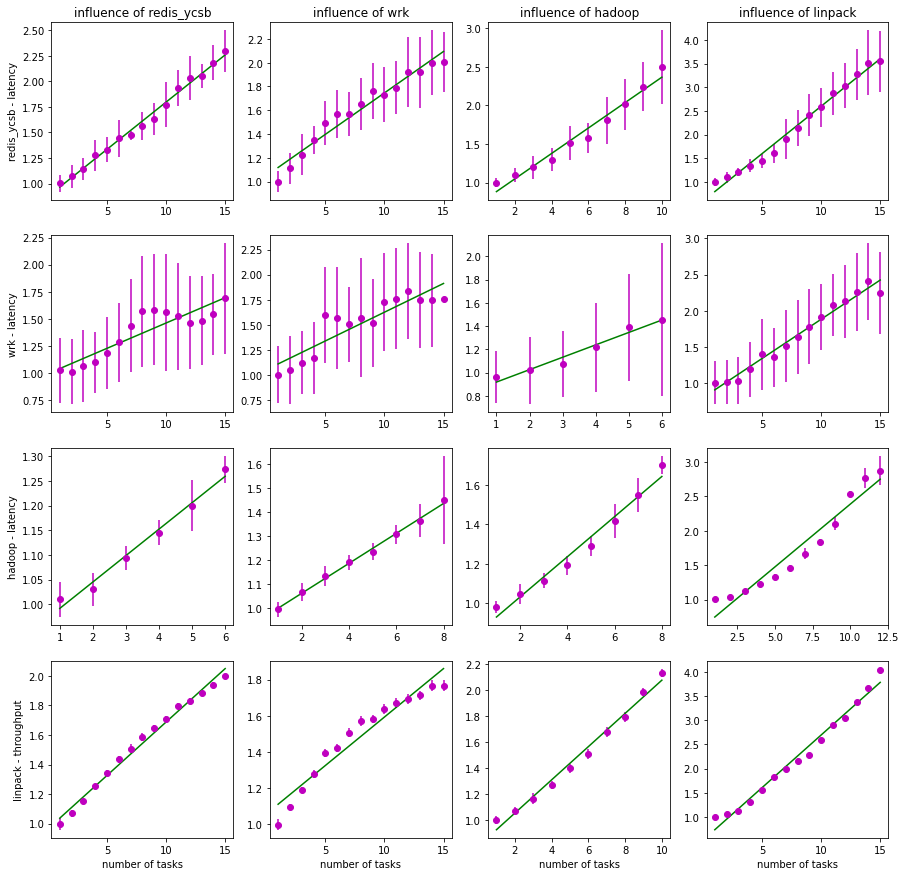

In [16]:
analyzeInterferenceGrid(s3, inverse_throughput_y=True, savefig=True)

In [13]:
formatInterferenceMatrixInGoFormat([s3, s4])

"baati": CoefficientsMatrix{{0.09236406129745652,0.06968222664414211,0.1647130881065321,0.20015221017304366},
{0.0466460482266046,0.05732161544142513,0.10657494482534081,0.10810948076749577},
{0.05359758455154095,0.062162787980730924,0.10183621207551628,0.18190055622891266},
{0.07236663478169568,0.053645734317726616,0.12738164345964662,0.21759115500509985},
},
"dosa": CoefficientsMatrix{{0.0437716396715501,0.05309571481979834,0.05778327994778269,0.0478036633107744},
{0.13532284678468662,0.10337024868620512,0.1644856778556154,0.133996920283637},
{0.030551469559096957,0.025204660199400788,0.2617647088479882,0.04293269861596552},
{0.06232254815329062,0.060185071267793024,0.05227936747270895,0.10634860864271509},
},


In [4]:
def readExpSeries(options):
    tasks = ["redis_ycsb", "wrk", "hadoop", "linpack"]
    synthetic_tasks = ["filebench", "netperf", "unixbench"]
    tasks_list = [tasks, tasks, synthetic_tasks, tasks]
    paths = ["2more_tasks", "3more_tasks_hadoop", "5synthetic", "6cpu_diff"]
    hadoop2 = {"hadoopslave": 2}
    task_counts = [{}, hadoop2, hadoop2, hadoop2]
    exp_series_list = []
    for ts, path, task_count in zip(tasks_list, paths, task_counts):
        exp_series_list.append(ExperimentSeries(os.path.join("data", path), ts, task_count, options))
    for exp_series in exp_series_list:
        readPerfVsCpu(exp_series)
    return exp_series_list
    
exp_series_list = readExpSeries({})
s2, s3, s5, s6 = exp_series_list
#exp_series = readExpSeries({"interval_boundaries": "first_plus_interval"})

Found 15 experiment in series 2more_tasks
Found 12 experiment in series 3more_tasks_hadoop
Found 8 experiment in series 5synthetic
Found 3 experiment in series 6cpu_diff
perf vs cpu data/2more_tasks
Getting perf data
Aggregating perf data
Getting cpu data
Aggregating cpu data
perf vs cpu data/3more_tasks_hadoop
Getting perf data
Aggregating perf data
Getting cpu data
Aggregating cpu data
perf vs cpu data/5synthetic
Getting perf data
Aggregating perf data
Getting cpu data
Aggregating cpu data
perf vs cpu data/6cpu_diff
Getting perf data
Aggregating perf data
Getting cpu data
Aggregating cpu data


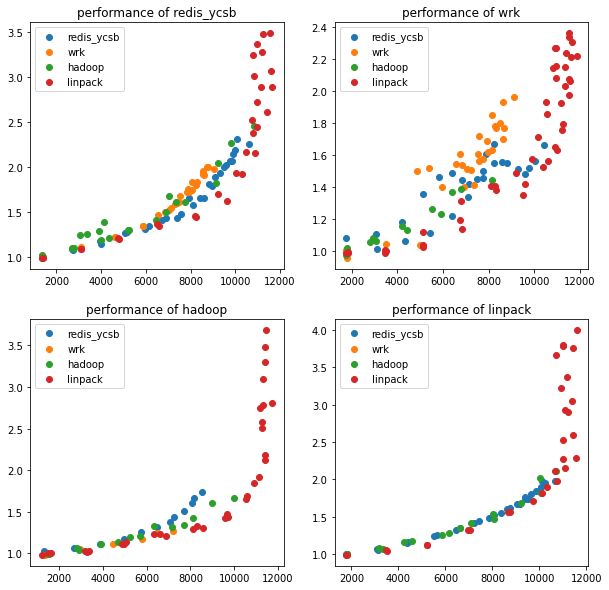

In [84]:
printPerfVsCpuMultipleSeries([s2, s3, s6])

In [8]:
readPerfVsCpu(s3)
printPerfVsCpuMultipleSeries([s3])

perf vs cpu data/3more_tasks_hadoop
Getting perf data
Aggregating perf data
Getting cpu data


ValueError: No data samples for {'expid': '805wrk', 't1': 'wrk', 't2': 'wrk', 'ai_no': 1, 'ai_role': 'apache', 'tasks': 15}

[[0.01664118]
 [0.01033656]
 [0.00530761]]


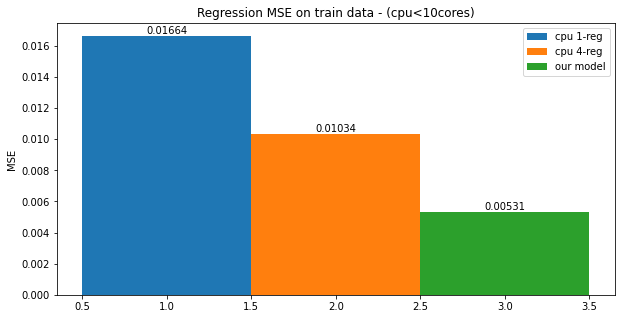

[[0.10855242]
 [0.08507608]
 [0.0068349 ]]


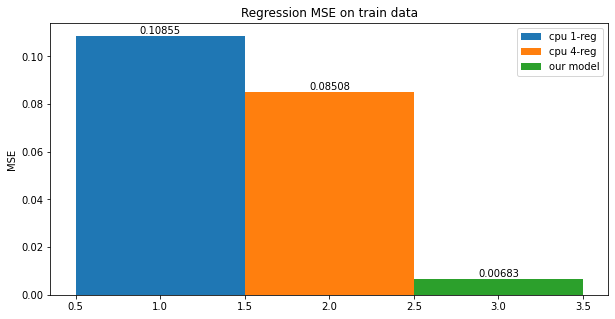

In [87]:
def getMSEForExperimentSeries(exp_series, limits):
    regression_levels = ["all", "t1", "t2"]
    x_labels = ["avg_cpu", "avg_cpu", "tasks"]
    results = np.zeros((len(limits), len(regression_levels)))
    for i, limit in enumerate(limits):
        for j, regression_level in enumerate(regression_levels):
            results[i, j] = computeMSE(exp_series, x_labels[j], regression_level, limit)
    return results

limits = [10000., 12000.]
s2_mse = getMSEForExperimentSeries(s2, limits)
s3_mse = getMSEForExperimentSeries(s3, limits)
def printMSEBarChart(data, title, precision=5):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    labels = ["cpu 1-reg", "cpu 4-reg", "our model"]
    rects = []
    for i, series_label in enumerate(zip(data, labels)):
        series, label = series_label
        series = [round(v, precision) for v in series]
        xs = [i + 1 + 4 * j for j in range(len(series))]
        rects.append(ax.bar(xs, series, 1., label=label))
    ax.set_title(title)
    ax.set_ylabel("MSE")
    for rects1 in rects:
        for rect in rects1:
            height = rect.get_height()
            ax.annotate(f"{height}", xy=(rect.get_x() + rect.get_width() / 2, height),
                ha='center', va='bottom')
    ax.legend()
    plt.show()
title = "Regression MSE on train data"
limit = s2_mse[0].reshape((-1, 1))
no_limit = s2_mse[1].reshape((-1, 1))
print(limit)
printMSEBarChart(limit, "Regression MSE on train data - (cpu<10cores)")
print(no_limit)
printMSEBarChart(no_limit, "Regression MSE on train data")

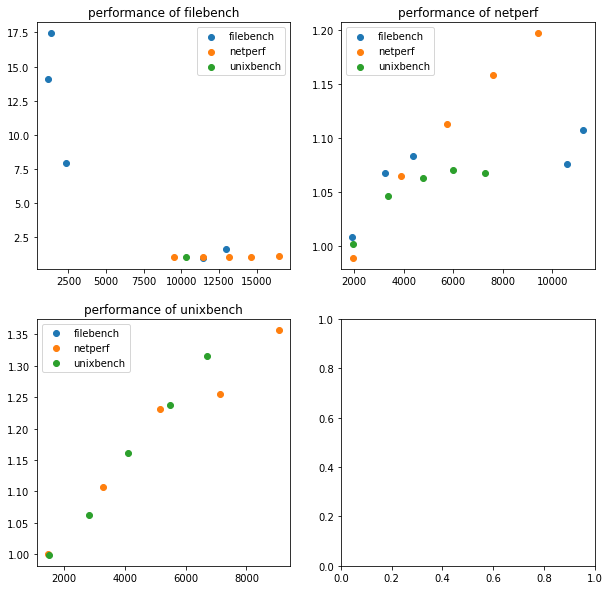

In [43]:
printPerfVsCpuMultipleSeries([s5])

Found 8 experiment in series 5synthetic
perf vs cpu data/5synthetic
Getting perf data
Aggregating perf data
Getting cpu data
Aggregating cpu data


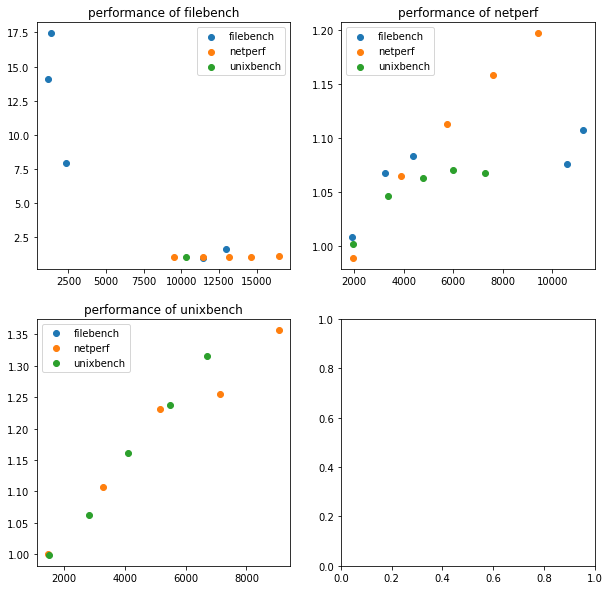

In [102]:
tasks = ["filebench", "netperf", "unixbench"]
path = "5synthetic"
s5 = ExperimentSeries(os.path.join("data", path), tasks, {}, {})
readPerfVsCpu(s5)
printPerfVsCpu(s5)

2more_tasks


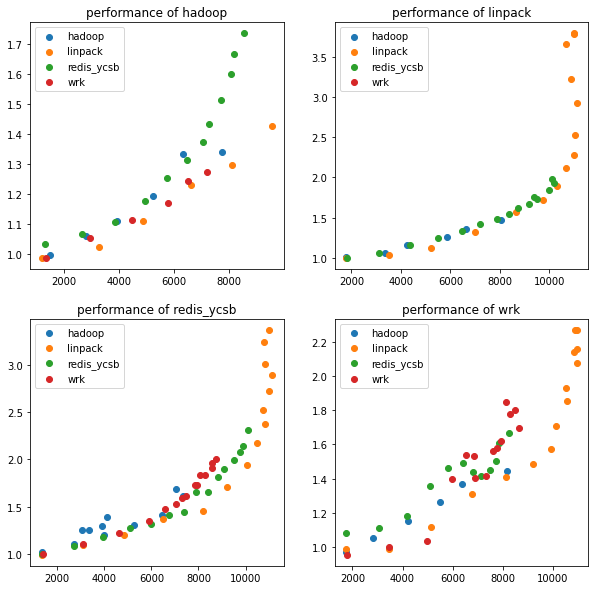

3more_tasks_hadoop


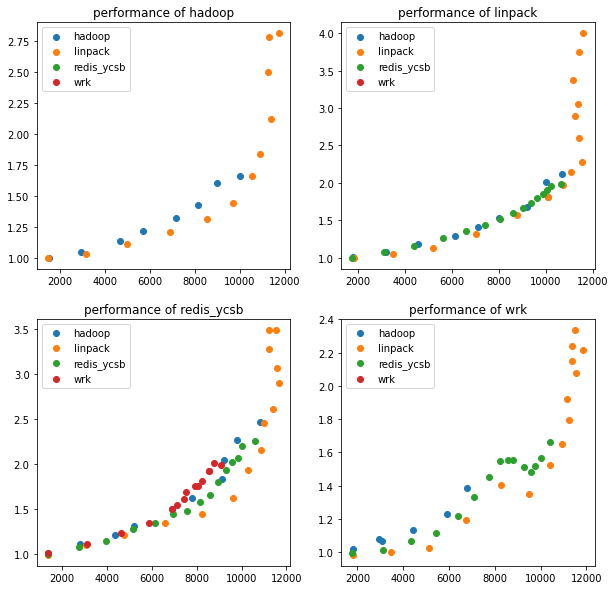

5synthetic


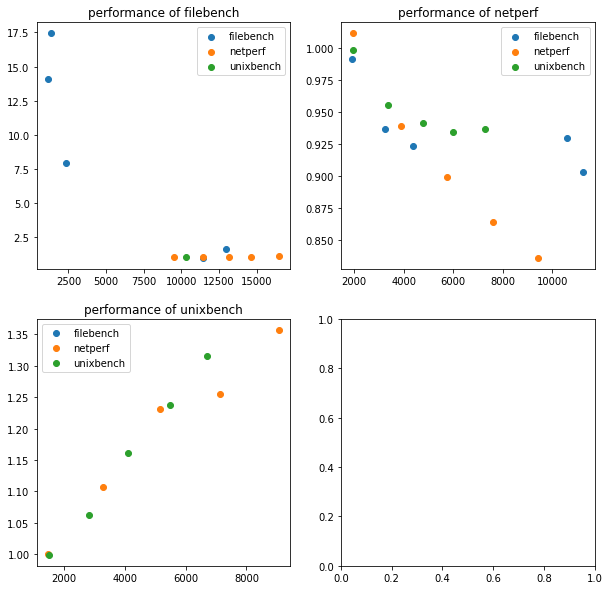

6cpu_diff


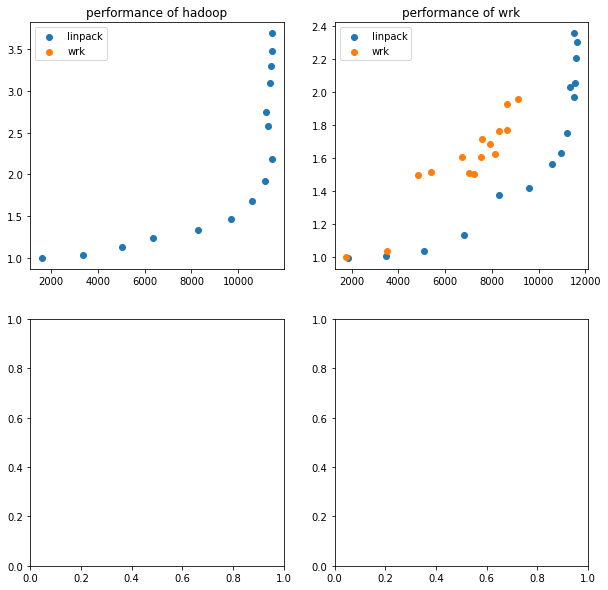

In [100]:
for exp_series1 in exp_series_list:
    print(f"{exp_series1.name}")
    printPerfVsCpu(exp_series1, exp_series1.df)

In [41]:
df = res_s5["perf_vs_cpu"]
pd.set_option("display.max_columns", 30)
#cols = ["t1", "t2", "tasks"]
#cols += [c for c in df.columns if ("throughput" in c) or ("cpu" in c)]
df.loc[(df["t1"] == "filebench") & (df["ai_no"] == 1), :]

,expid,t1,t2,tasks,avg_cpu,std_cpu,cpu_samples_count,ai_no,avg_throughput,std_throughput,throughput_samples_count,throughput_quantile25,throughput_quantile50,throughput_quantile75,avg_bandwidth,std_bandwidth,bandwidth_samples_count,bandwidth_quantile25,bandwidth_quantile50,bandwidth_quantile75,avg_throughput_rescaled,std_throughput_rescaled,avg_bandwidth_rescaled,std_bandwidth_rescaled
0,500filebench,filebench,filebench,1,11470.727273,1970.872352,22,1,201693.665625,8682.401058,16.0,196578.22575,199446.5685,203334.61500,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.043047,NaN,NaN
1,500filebench,filebench,filebench,2,12964.461538,6273.781474,52,1,118669.111368,35065.386996,19.0,120204.80400,126320.1450,138698.93350,NaN,NaN,NaN,NaN,NaN,NaN,0.588363,0.173855,NaN,NaN
3,500filebench,filebench,filebench,3,2362.242063,2588.759453,83,1,24202.418917,5783.831098,12.0,20055.09900,21101.9580,27373.48600,NaN,NaN,NaN,NaN,NaN,NaN,0.119996,0.028676,NaN,NaN
6,500filebench,filebench,filebench,4,1151.310084,1620.884544,137,1,13607.200273,7112.411229,11.0,11448.46800,12365.8710,15041.28900,NaN,NaN,NaN,NaN,NaN,NaN,0.067465,0.035263,NaN,NaN
10,500filebench,filebench,filebench,5,1336.287500,2348.810708,76,1,10984.617500,8659.191739,4.0,5630.11675,8325.0910,13679.59175,NaN,NaN,NaN,NaN,NaN,NaN,0.054462,0.042932,NaN,NaN
15,501filebench_netperf,filebench,netperf,1,9492.478261,2299.516033,23,1,192326.479824,9504.110579,17.0,194578.35700,195663.3370,196271.01800,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.049417,NaN,NaN
16,501filebench_netperf,filebench,netperf,2,11448.887352,1801.493072,68,1,189939.441875,7417.699177,16.0,190304.29450,192630.9935,193103.68875,NaN,NaN,NaN,NaN,NaN,NaN,0.987589,0.038568,NaN,NaN
18,501filebench_netperf,filebench,netperf,3,13156.130435,1519.268635,116,1,189470.608412,5802.787007,17.0,189229.05700,192487.0310,193187.54400,NaN,NaN,NaN,NaN,NaN,NaN,0.985151,0.030172,NaN,NaN
21,501filebench_netperf,filebench,netperf,4,14646.506258,1940.796685,160,1,185278.031111,9789.710885,18.0,179854.51425,189971.4600,192063.34800,NaN,NaN,NaN,NaN,NaN,NaN,0.963352,0.050902,NaN,NaN
25,501filebench_netperf,filebench,netperf,5,16470.964912,2223.041009,165,1,178678.375077,11868.604443,13.0,168647.16100,176326.7280,192136.82900,NaN,NaN,NaN,NaN,NaN,NaN,0.929037,0.061711,NaN,NaN


In [1]:
data = res_s5["perf_vs_cpu"]
#printPerfVsCpu(res_s5["perf_vs_cpu"])
analyzeInterferenceGrid([s5], [res_s5["perf_vs_cpu"]])
#rescalePerfVsCpu(s5, data)
data.loc[(data["t1"] == "netperf") & (data["ai_no"] == 1), :]

NameError: name 'res_s5' is not defined

# Performance vs cpu

101redis_ycsb
320redis_ycsb
102redis_ycsb_wrk
172redis_ycsb_hadoop
202redis_ycsb_hadoop
103redis_ycsb_linpack
323redis_ycsb_linpack
174wrk_redis_ycsb
304wrk_redis_ycsb
106wrk
108wrk_hadoop
306wrk_hadoop
107wrk_linpack
307wrk_linpack
178hadoop_redis_ycsb
114hadoop_wrk
116hadoop
230hadoop
115hadoop_linpack
271hadoop_linpack
109linpack_redis_ycsb
332linpack_redis_ycsb
112linpack_hadoop
214linpack_hadoop
111linpack
335linpack


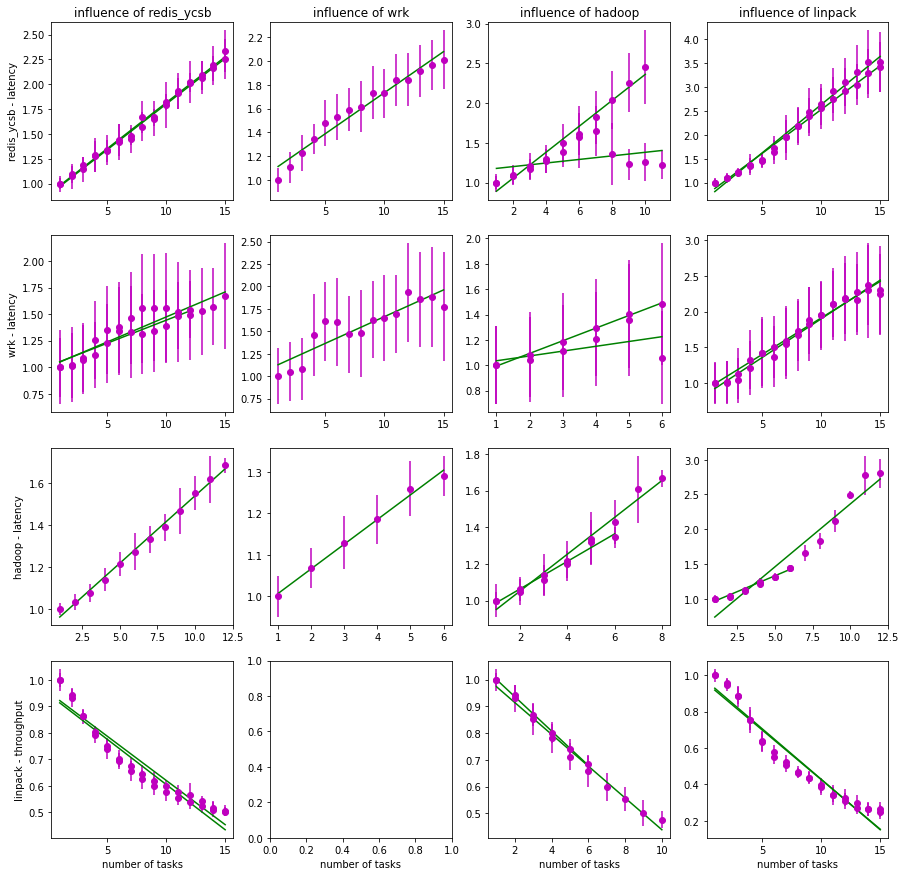

array([[[0.09251838, 0.06896643, 0.02253664, 0.18303585],
        [0.04346423, 0.05950165, 0.0996998 , 0.10239049],
        [0.06407131, 0.05943509, 0.07495003, 0.0910561 ],
        [0.03340253, 0.        , 0.06426189, 0.05550344]],

       [[0.09202281, 0.        , 0.16339007, 0.20164456],
        [0.04721765, 0.        , 0.03799307, 0.10846218],
        [0.        , 0.        , 0.10029655, 0.18047888],
        [0.03414553, 0.        , 0.05947115, 0.05454094]]])

In [53]:
analyzeInterferenceGridMultipleSeries([s2, s3])

In [95]:
result = {}
for t in s2.tasks:
    expid = s2.getExperiment(t, t)
    print(expid.expid)
    result[expid.expid] = readExp(expid)
print(result.keys())

completion_time = []
for expid, df in result.items():
    print(expid)
    c = df.loc[df["ai_name"] == "ai_1" , "app_completion_time"].mean()
    completion_time.append(c)
print(completion_time)
    

101redis_ycsb
106wrk
116hadoop
111linpack
dict_keys(['101redis_ycsb', '106wrk', '116hadoop', '111linpack'])
101redis_ycsb
106wrk
116hadoop
111linpack
[1.8918032786885246, 1.4427906976744187, 44.79381443298969, 17.24773413897281]


In [ ]:
s7 = ExperimentSeries("data/7cpu_diff_dosa", ["redis_ycsb", "wrk", "hadoop", "linpack"], {"hadoopslave" : 2}, {})
readPerfVsCpu(s7)
printPerfVsCpu(s7)